In [1]:
from os.path import join, exists
from os import makedirs
from glob import glob

import numpy as np
import pandas as pd

import pickle

from tqdm import tqdm

import json

from PIL import Image, ImageFilter

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter

from nilearn import image, plotting, masking

from joblib import Memory

---

In [2]:
import torch

# device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = 'cpu'
device

'cpu'

In [3]:
dir_root = '/mnt/ext5/DRN'

dir_behav = join(dir_root, 'behav_data')

dir_fmri = join(dir_root,'fmri_data')
dir_mask = join(dir_fmri, 'masks')
dir_model = join(dir_root,'model')

---

In [4]:
scaler = StandardScaler()

---

In [5]:
def state_processing(obs):
    vis_obs = []

    for _obs in obs:
        ## _obs.shape = (1, 72, 128, 3)
        vis_obs.append(_obs)

    ## visual observation [(1, 72, 128, 3) x 4]
    vis_obs = np.concatenate(vis_obs, axis=-1)
    ## visual observation (1, 72, 128, 12)
    vis_obs = np.transpose(vis_obs, (0, 3, 1, 2))
    vis_obs = (vis_obs * 255).astype(np.uint8)
    
    ## visual observation (1, 12, 72, 128)
    return vis_obs

In [6]:
def convert_time_to_sec(Time):
    m, s, ds = np.array(Time.split('-')).astype(int)
    return m*60+s+0.001*ds

---

In [7]:
## time points per a run
TR = 0.5
TPs = 1400 - 12

In [8]:
subj = 'DRN11'

---

### behavioral data

In [9]:
def get_data_behav(subj, resolution=(128,72)):
    
    dir_work = join(dir_behav,subj,'resized_%dx%d'%(resolution[0],resolution[1]))
    list_run = ['Run%d'%(ii+1) for ii in range(len(glob(join(dir_work,'*'))))]
    
    ## i) Screen Shots
    list_png = {}
    ## ii) Actions
    behav = {}
    ## iii) onset times
    list_onsettime = {}
    ## iv) episode
    list_episode = {}
    for run in list_run:
        ## i)
        list_png[run] = np.array(sorted(glob(join(dir_work,run,'*.png'))))
        ## ii)
        with open(join(dir_work,run,'log.json'),'r') as f:
            behav[run] = json.load(f)
#         print('%s: actions (%d) / pngs (%d)'%(run, len(behav[run]), len(list_png[run])))

        ## iii)
        tmp = []
        ### iv)
        tmp2 = []
        for dict_ in behav[run]:
            tmp.append(convert_time_to_sec(dict_['Time']))
            tmp2.append(dict_['Episode'])
        list_onsettime[run] = np.array(tmp)
        list_episode[run] = np.array(tmp2)
    
    return list_png, list_onsettime, list_episode

---

In [10]:
def get_idx_input(subj, run, shift=0):
    nFrameStack = 4
    TR = 0.5
    
    _, list_onsettime, _ = get_data_behav(subj)

    onsettimes = list_onsettime[run]
    onsettimes = onsettimes[onsettimes<700-shift]

    ## A set of the last indices for each episode except the last episode
    idx_final = np.concatenate([np.where(np.diff(onsettimes)>TR)[0], [onsettimes.shape[0]-1]])
    idx_initial = np.concatenate([[0],idx_final[:-1]+1])
    assert idx_initial.shape == idx_final.shape

    idx_input = {}
    idx_epi = {}
    for ii, (idx_i, idx_f) in enumerate(zip(idx_initial, idx_final)):
        episode = 'episode:%02d'%(ii+1)

        ## the times of the initial and final frame
        ta, tb = onsettimes[idx_i], onsettimes[idx_f]
        ## the number of frames at the episode
        n_frame = int(idx_f-idx_i+1)

        ## The fMRI image corresponding to the first frame of this episode
        a = ta - ta%TR
        ## The fMRI image corresponding to the final frame of this episode
        b = tb - tb%TR

        ## The number of fMRI images representing the corresponding episode.
        n_epi = int((b-a)/TR + 1)
        if n_epi <= 1:
            continue

        ## The fMRI indices that make up each episode
        timepoint_epi = np.arange(a,b+TR,TR)+shift
        timepoint_epi = timepoint_epi[timepoint_epi<700]
        idx_epi[episode] = (2*(timepoint_epi-6)).astype(int)

        ## an input set to forward via a model
        idx_input[episode] = np.zeros((n_epi,nFrameStack)).astype(int)

        ## the last input
        idx_input[episode][-1] = [idx_f-nFrameStack+1+jj for jj in range(nFrameStack)]

        ## the rest of them
        didx = (idx_f-nFrameStack-idx_i)*TR/(b-a+1.e-8)
        for jj in range(n_epi-1):
            idx_input[episode][jj] = [int(idx_i+didx*jj+kk) for kk in range(nFrameStack)]

    for episode, input_ in idx_input.items():
        assert input_.shape[0] == idx_epi[episode].shape[0]
    
    return idx_input, idx_epi

---

the config

In [11]:
with open(join(dir_model,'drone_hanyang_mlagent.ppo/drone_hanyang_mlagent.json'),'r') as f:
    hanyang = json.load(f)
hanyang

{'env': {'name': 'drone_hanyang_mlagent', 'render': 'True', 'time_scale': 3.0},
 'agent': {'name': 'ppo',
  'network': 'continuous_policy_value',
  'head': 'cnn',
  'gamma': 0.95,
  'batch_size': 32,
  'n_step': 128,
  'n_epoch': 3,
  '_lambda': 0.95,
  'epsilon_clip': 0.1,
  'vf_coef': 1.0,
  'ent_coef': 0.01,
  'clip_grad_norm': 1.0,
  'use_standardization': 'True',
  'lr_decay': 'False'},
 'optim': {'name': 'adam', 'lr': 0.00025},
 'train': {'training': 'True',
  'load_path': './logs/drone_hanyang_mlagent/ppo/20230311094756544355/',
  'run_step': 30000000,
  'print_period': 10000,
  'save_period': 500000,
  'eval_iteration': 3,
  'record': 'False',
  'record_period': 1000000,
  'distributed_batch_size': 256,
  'update_period': "agent['n_step']",
  'num_workers': 5}}

## load pretrained parameters

In [12]:
ckpt = torch.load(
    join(dir_model,'drone_hanyang_mlagent.ppo/level2.ckpt')
    , map_location=device
)

In [13]:
for key1, dict_ in ckpt.items():
    print('################')
    print(key1)
    print('################')
    for key2, value in dict_.items():
        if type(value) is not dict:
            print('%s\n%s\n'%(key2,value.shape))
        else:
            break

################
network
################
head.conv1.weight
torch.Size([32, 12, 8, 8])

head.conv1.bias
torch.Size([32])

head.conv2.weight
torch.Size([64, 32, 4, 4])

head.conv2.bias
torch.Size([64])

head.conv3.weight
torch.Size([64, 64, 3, 3])

head.conv3.bias
torch.Size([64])

l.weight
torch.Size([512, 3840])

l.bias
torch.Size([512])

mu.weight
torch.Size([3, 512])

mu.bias
torch.Size([3])

log_std.weight
torch.Size([3, 512])

log_std.bias
torch.Size([3])

v.weight
torch.Size([1, 512])

v.bias
torch.Size([1])

################
optimizer
################


---

# Encoding model

#### Network

In [14]:
from core.network import *

InputShape = (12,72,128)
network = policy_value.ContinuousPolicyValue(D_in=InputShape, D_out=3, D_hidden=512, head='cnn')
network.eval().to(device)

ContinuousPolicyValue(
  (head): CNN(
    (conv1): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (l): Linear(in_features=3840, out_features=512, bias=True)
  (mu): Linear(in_features=512, out_features=3, bias=True)
  (log_std): Linear(in_features=512, out_features=3, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=True)
)

In [15]:
input_ = torch.rand((5,*InputShape))
print(input_.shape)
(mu, std, v), (conv1, conv2, conv3) = network(input_.to(device))

conv1.shape, conv2.shape, conv3.shape, mu.shape, std.shape, v.shape

torch.Size([5, 12, 72, 128])


(torch.Size([5, 32, 17, 31]),
 torch.Size([5, 64, 7, 14]),
 torch.Size([5, 64, 5, 12]),
 torch.Size([5, 3]),
 torch.Size([5, 3]),
 torch.Size([5, 1]))

#### copy parameters `network.head.weight = torch.nn.Parameter(ckpt['network'].head)`

In [16]:
network.load_state_dict(ckpt['network'])

<All keys matched successfully>

---

In [17]:
n_components = 200
pipeline_pca = Pipeline(
    [
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ]
)
pipeline_pca

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=200))])

In [18]:
def do_forward(subj, run, shift=0):
    ## ======================= setup ======================= ##
    list_png, _, _ = get_data_behav(subj)
    idx_input, idx_epi = get_idx_input(subj=subj, run=run, shift=shift)

    for ii, (episode, indices) in enumerate(idx_epi.items()):
        ## 해당 EPI index에 매칭되는 png의 index들
        tmp = idx_input[episode]

        ## 해당 RUN에 input으로 쓰일 모든 png fname 들
        if ii > 0:
            input_fname = np.concatenate(
                [
                    input_fname,
                    list_png[run][tmp]
                ],
                axis=0
            )
        else:
            input_fname = list_png[run][tmp]

    ## (batch size of Run, 4)
    (batch, _) = input_fname.shape

    ## ======================= input ======================= ##
    ## Actual input values to be entered into the network
    input_ = np.zeros((batch,12,72,128), dtype=np.uint8)

    for timepoint, fnames in enumerate(tqdm(input_fname)):
        ## 4 frames (1,72,128,3) 를 numpy 로 불러와서 쌓음
        tmp = np.stack(
            [np.asarray(Image.open(f)).reshape((1,72,128,3)) for f in fnames],
            axis=0
        )

        ## 이미지 전처리 (4, 1, 72, 128, 3) -> (12, 72, 128, 3)
        input_[timepoint] = state_processing(tmp)

    del tmp
    ## 이미지를 torch.tensor 로 변경
    input_ = torch.from_numpy(input_)
    ## ========================== Forward ========================== ##
    ## 쌓은 frame 들을 network에 입력
    with torch.no_grad():
        output_ = network(input_.to(device))

    return output_

---

#### Perform GLM (Generalized Linear Model) with the value function.

In [19]:
dir_reg = join(dir_behav, 'regressors/AM/value')

100%|██████████| 1316/1316 [00:01<00:00, 676.20it/s]


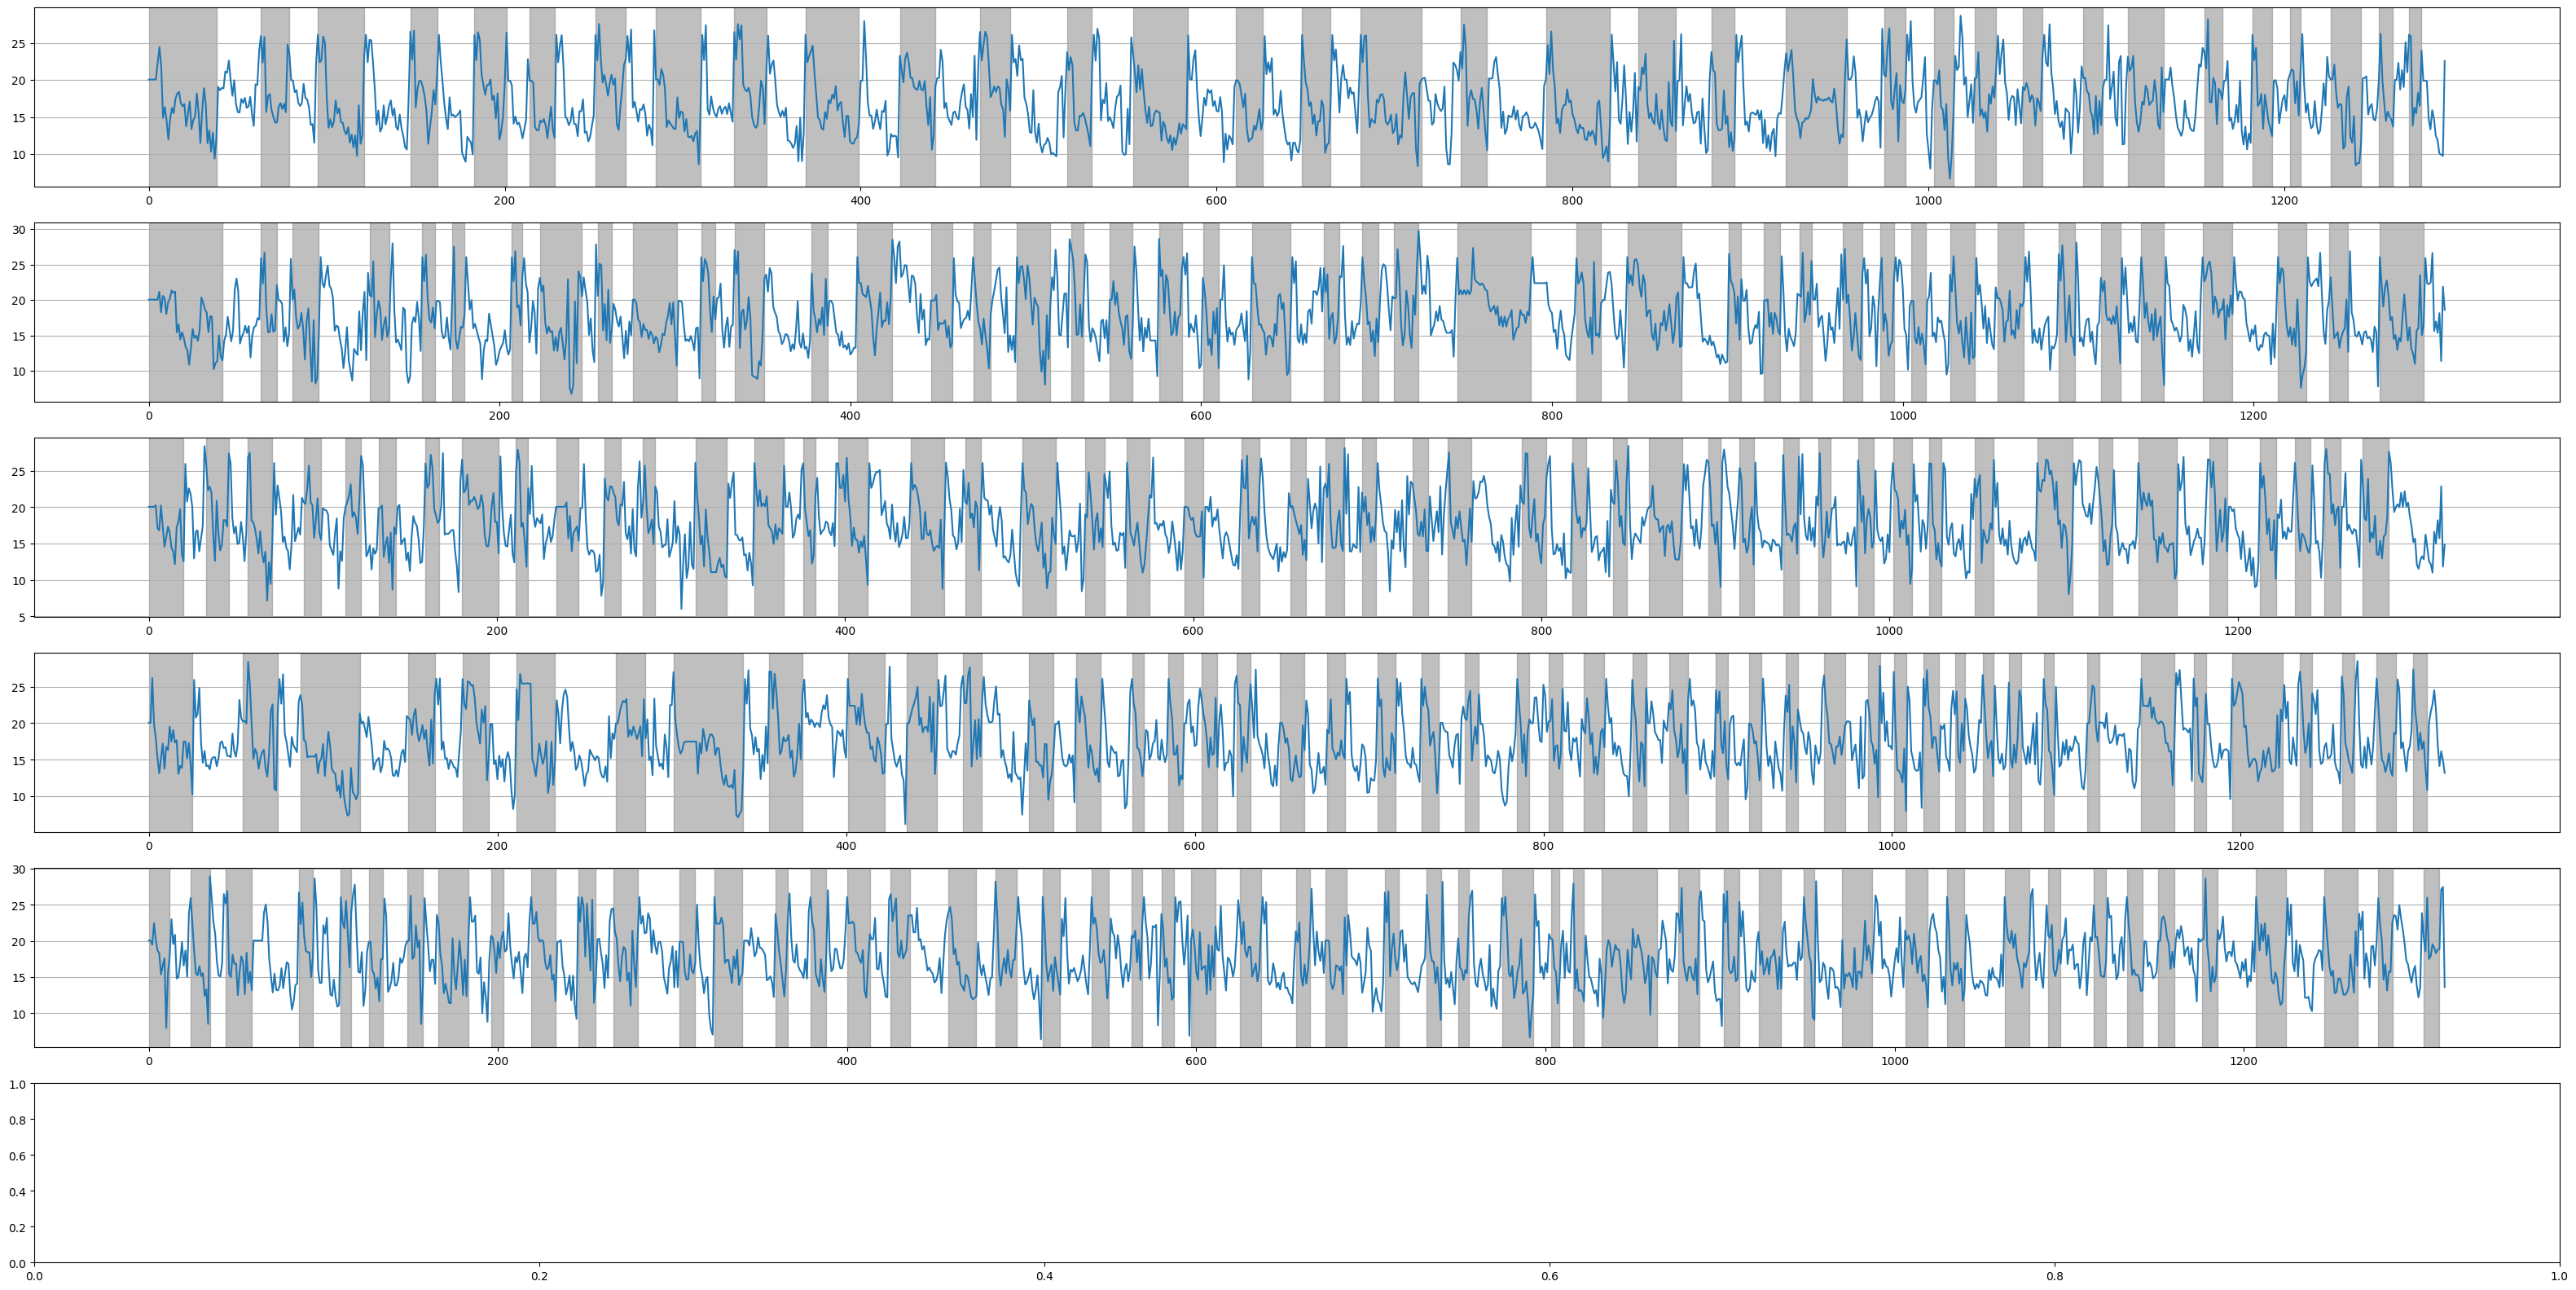

In [20]:
fig, axs = plt.subplots(nrows=6, figsize=(40,20))

_, list_onsettime, list_episode = get_data_behav(subj)
for rr, (run, onset) in enumerate(list_onsettime.items()):
    ## onsettime
    idx_input, idx_epi = get_idx_input(subj=subj, run=run, shift=0)
    for ii, (key, val) in enumerate(idx_input.items()):
        if ii > 0:
            list_idx = np.concatenate([list_idx, val[:,0]])
        else:
            list_idx = val[:,0]
    ## episode
    episode = list_episode[run][list_idx]
    
    ## value function
    (_,_,value),(_,_,_) = do_forward(subj, run, shift=0)
    value = np.squeeze(value.numpy())
    
    ## plot
    ax = axs[rr]
    x = range(len(value))
    ax.plot(x,value)
    ylim = ax.get_ylim()
    ax.grid(axis='y')
    ax.fill_between(
                x=x,
                y1=0, y2=40,
                where=(episode%2==0),
                color='gray', alpha=0.5
            )
    ax.set_ylim(ylim)
    
    ## make regressor
    reg = []
    for onset_, value_ in zip(onset[list_idx], value):
        reg.append('%.2f*%.3f'%(onset_,value_))
    reg = np.array(reg)
    
    # save the result
    np.savetxt(
        join(dir_reg, '%s.r%02d.value.txt'%(subj,rr+1)),
        X=reg,
        fmt='%s', delimiter=' ', newline=' '
    )

---